In [1]:
import sys
sys.path.append('../python/')
import pandas as pd
import numpy as np
import xarray as xr
import scipy.signal as sig
import matplotlib.pyplot as plt
import cartopy.crs as crs
import helpers as hh

In [3]:
%matplotlib nbagg

In [92]:
from IPython.display import set_matplotlib_formats
%matplotlib inline

set_matplotlib_formats('png', 'pdf')

**NOTE**: alternative to my own implementation of an extrema finder would be to use e.g. a smoothing spline on the data first (to reduce 'flat' sensor responses stuck on a level), and then scipy.signal.argrelmin/max.

In [2]:
# scipy.signal.argrelmin/max can't find 'flat' extrema, so here is my own algorithm
# it does two sweeps:
# 1) search for extrema in rolling window; take only those that appear at least twice, 
#    since a leading or trailing edge of the window might otherwise be interpreted as an extremum
# 2) discard any extrema within a window width of a deeper one ('prune')

def prune(x, func, period):
    dx = np.diff(x.index) < pd.Timedelta(period).asm8
    if not dx.any():
        return None
    i = func(np.vstack((x.values.flatten()[1:], x.values.flatten()[:-1])), 0)
    return x.index.drop(x.iloc[np.where(dx)[0] + i[dx]].index)

def extrema(x, func, period):
    # NOTE: argmin/argmax interprets NaN as minimum/maximum
    r = x.rolling(period)
    ix = np.arange(x.shape[0])
    # NOTE: .count() returns the non-NaN length, len() the complete
    # however, if all data in a rolling window is NaN, NaN is automatically returned no matter
    # what the function (min_periods keyword)
    idx = r.apply(func).values.flatten() + ix - r.apply(len).values.flatten() + 1
    idx, count = np.unique(idx[np.isfinite(idx)].astype(int), return_counts=True)
    i = idx[count>1]
    y = x.iloc[i].dropna()
    while i is not None:
        i = prune(y, func, period)
        if i is not None:
            y = x.loc[i]
    return y.index

In [81]:
def composite(var, locs, window, fillna=False):
    ar = lambda x: np.array(x, dtype='datetime64', ndmin=2)
    dt = pd.Timedelta(window)
    n = dt / var.index.freq.delta
    i = np.abs(ar(var.index).T - ar(locs)) <= dt.asm8
    k = i.sum(0) == 2 * n + 1
    # don't take any event too close to the edge
    i = np.expand_dims(i[:, k], 2).transpose(2, 1, 0)
    x, j = np.broadcast_arrays(np.expand_dims(var, 2).transpose(1, 2, 0), i)
    c = x[j].reshape((var.shape[1], i.shape[1], -1))
    if fillna:
        j = np.isnan(c)
        c[j] = np.nanmean(c, 1, keepdims=True).repeat(c.shape[1], 1)[j]
    return xr.DataArray(c, coords=[
        ('var', var.columns), ('events', locs[k]), ('dt', np.arange(-n, n+1))])

def label(full_idx, partial_idx):
    i = np.zeros(full_idx.size, dtype=int)
    i[full_idx.get_indexer(partial_idx)] = 1
    return i

## Stations further south

Since coastal lows happen when there is a moving anticyclone passing throught the midlatitude storm track, one way of identifying them could be to compare pressure at Punta Lengua de Vaca (*PLV*) to a station further south. The best candidate from our network seems to be Senda Darwin (*CNSD*).

In [206]:
with pd.HDFStore('../../data/CEAZAMet/stations.h5') as S:
    sta= S['stations']
    flds = S['fields']

In [402]:
pf = flds.xs('pa_hpa', 0, 'field').drop('full', 1).join(sta[['lon', 'lat', 'full']])
table = pf[pf.lat.astype(float) < -35]
table

unit elev                first        lon        lat  \
station sensor_code                                                        
BK      BKPA         hPa    2                       -74.01520  -47.77000   
CNPW    CNPWPA       hPa    2  2010-01-13 20:15:00  -67.61519  -54.93208   
CNSD    CNSDPA       hPa    2  2010-03-23 11:00:00  -73.67206  -41.88500   
DICHA   DICHAPA      hPa    2  2016-05-17 12:50:00  -72.93268  -36.54483   
LB      LBPA         hPa    2  2013-05-14 12:40:00  -72.30889  -41.49583   
PUY     PUYPA        hPa    2  2014-04-11 00:11:00  -72.73900  -44.58770   
RLCV    RLCVMETPA    hPa    2  2017-09-02 03:40:00  -72.83448  -41.63638   
TRT     TRTPA        hPa    2  2015-12-15 17:19:00  -73.54117  -47.80361   

                                        full  
station sensor_code                           
BK      BKPA              Canal Baker [Boya]  
CNPW    CNPWPA       Puerto Williams [OMORA]  
CNSD    CNSDPA                  Senda Darwin  
DICHA   DICHAPA                      Dichato  
LB      LBPA                  Cochamó [LOBO]  
PUY     PUYPA                      Puyuhuapi  
RLCV    RLCVMETPA      Seno Reloncaví [Imar]  
TRT     TRTPA                         Tortel

<IPython.core.display.Javascript object>


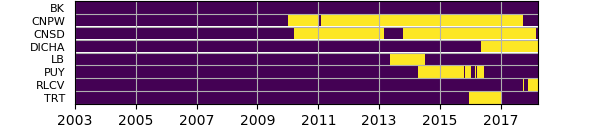

In [400]:
from plots import availability_matrix
p35 = D['pa_hpa'][table.index.get_level_values('station')].xs('prom', 1, 'aggr')
availability_matrix(p35, bottom=.2)

In [213]:
slp = xr.open_dataarray('../../data/analyses/ERA/ERA-SLP-dailymean.nc')
# this sets the time from the cdo averaging (18:00h every day) to simply the day
slp['time'] = slp.indexes['time'].date.astype('datetime64')

S = pd.HDFStore('../../data/CEAZAMet/station_data_new.h5')

In [70]:
# these are all variables currently of interest
D = pd.concat([
    S['pa_hpa'][['PLV', 'CNSD']],
    S['vv_ms'].xs('PLV', 1, 'station', drop_level=False),
    S['dv'].xs('PLV', 1, 'station', drop_level=False),    
    S['rs_w'].xs('PLV', 1, 'station', drop_level=False),
    S['ta_c'].xs('PLV', 1, 'station', drop_level=False)
], 1).xs('prom', 1, 'aggr').dropna(0, 'all').resample('h').first()
D.columns = D.columns.swaplevel(0, 1)

In [73]:
from formulae import wind
from filters import Lanczos

D = D['2016':]

# Detection

## Garreaud et al

<cite data-cite="2031184/86XEQ8JZ"></cite> use the following procedure:
1. Find minima in pressure at Punta Lengua de Vaca (*PLV*) within 5-day windows.
2. Select the ones with a 24-h pressure drop in excess of 5 hPa.
3. Wind speed in excess of 5 m s$^{-1}$ from between 140 and 235$^{\circ}$ during 24-h period preceeding the culmination (pressure minimum).

In [74]:
# form some derived properties

w10 = Lanczos(D, '10D')
# ws = Lanczos(D, '2D')
u, v = wind(D['vv_ms'], D['dv'])

# remove lowpass variability from pressure at CNSD and u, v winds
X = pd.concat((D[('pa_hpa', 'CNSD')], u, v), 1)
X = X - X.rolling(**w10.roll).apply(w10)

rs = D['rs_w']#.rolling(**ws.roll).apply(ws)# - D['rs_w'].rolling(**w10.roll).apply(w10)
X = pd.concat((D[('pa_hpa', 'PLV')], X, D['ta_c'], rs), 1)
X.columns = ['PLV', 'CNSD', 'u', 'v', 't', 'rs']

/home/arno/Documents/code/conda/envs/bayes/lib/python3.6/site-packages/ipykernel/kernelbase.py:399: PerformanceWarning: indexing past lexsort depth may impact performance.
  user_expressions, allow_stdin)


In [75]:
p = D[('pa_hpa', 'PLV')]['2016':] # <- some of the plots are for the whole time series
ix = extrema(p, np.argmin, '5D')  # Punta Lengua de Vaca

# Garreaud et al's measure
G = pd.concat((p, p.rolling('1D').max(), D['dv'].rolling('1D').mean(), D['vv_ms'].rolling('1D').max()), 1).loc[ix]
G.columns = ['p', 'p24', 'dv', 'vv']

# 24-h pressure drop > 5 hPa (rolling by default labels right edge - i.e. the window corresponds to the prior 24h)
g1 = G[(G['p24'] - G['p'] > 5)].index

g2 = G[(G['p24'] - G['p'] > 5) & (G['dv'] >= 140) & (G['dv'] <= 235) & (G['vv'] >= 5)].index

/home/arno/Documents/code/conda/envs/bayes/lib/python3.6/site-packages/ipykernel/kernelbase.py:399: PerformanceWarning: indexing past lexsort depth may impact performance.
  user_expressions, allow_stdin)


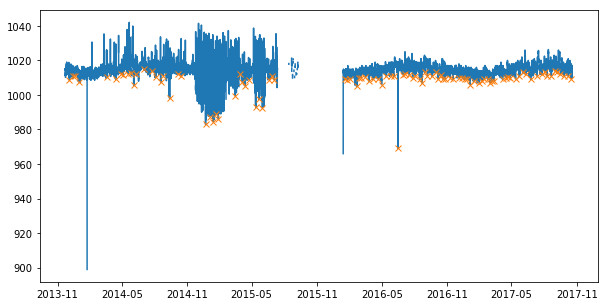

In [62]:
plt.figure(figsize=(10,5))
plt.plot(p)
plt.plot(p.loc[ix], 'x')

Punta Lengua de Vaca (*PLV*) pressure with extrema (5 day window) marked. Since the readings before 2016 are somewhat erratic, I use mostly the timeseries from 2016.

(1005, 1028)

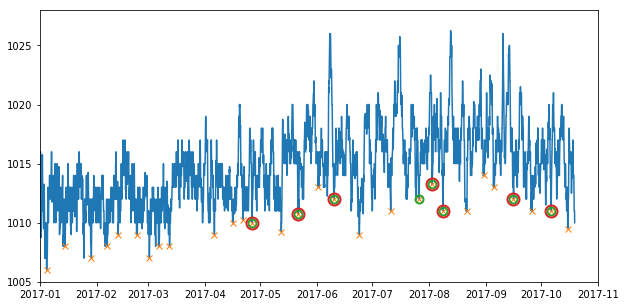

In [92]:
plt.figure(figsize=(10,5))
plt.plot(p)
plt.plot(p.loc[ix], 'x')
plt.plot(p.loc[g1], 'o', mfc='none', ms=8, markeredgewidth=2)
plt.plot(p.loc[g2], 'o', mfc='none', ms=12, markeredgewidth=2)
plt.gca().set_xlim('2017', '2017-11')
plt.gca().set_ylim(1005, 1028)

Closeup with initial minimums (orange crosses), and the Garreaud selection criteria: 24h pressure drop > 5 hPa (green circles) and wind-related ones (red circles). The wind-related selection criteria subtract few of the minima compared to the 24h pressure-drop one.

In [17]:
p = D['pa_hpa']

# 5 day mins / maxs
ix = extrema(p['PLV'], np.argmin, '5D')  # Punta Lengua de Vaca
jx = extrema(p['CNSD'], np.argmax, '5D') # Senda Darwin

# coastal low index based on maximum at CNSD occurring within 2 days prior to a minimum at PLV
r = pd.concat((p['CNSD'].loc[jx], p['PLV'].loc[ix]), 1).rolling('2D')
idx = pd.concat((r.count().iloc[:, 0], p['PLV'].loc[ix]), 1).dropna(0, 'any').index

(995, 1032)

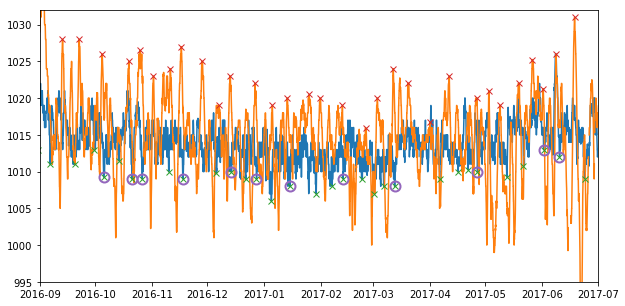

In [89]:
plt.figure(figsize=(10,5))
plt.plot(p)
plt.plot(p['PLV'].loc[ix], 'x')
plt.plot(p['CNSD'].loc[jx], 'x')
plt.plot(p['PLV'].loc[idx], 'o', mfc='none', ms=10, markeredgewidth=2)
plt.gca().set_xlim('2016-09', '2017-07')
plt.gca().set_ylim(995, 1032)

Selection method based on *PLV* (blue) and *CNSD* (orange) - circles enclose those minima at *PLV* that occur within 2 days of a maximum at *CNSD*.

In [140]:
import matplotlib.gridspec as gs

def label_plot(slp, c, labels, contours=None, maph=4, cb=.02, gridspec=None, **kwargs):
    br = lambda x: x[(x >= '2016') & (x < '2017-07')] + pd.Timedelta('4h')
    m, n = len(np.unique(labels)), len(c['var'])
    if gridspec is None:
        g = gs.GridSpec(maph + n, m)
    else:
        g = gs.GridSpecFromSubplotSpec(maph + n, m, subplot_spec=gridspec, **kwargs)       
    plt.set_cmap('coolwarm')
    mp = slp.mean('time')
    axs = [None] * (n + maph)
    keys = {}
    for i in range(m): # columns
        ax = plt.gcf().add_subplot(g[:maph, i], projection=crs.PlateCarree())
        p = slp.sel(time = br(c.indexes['events'][labels == i]).date.astype('datetime64')).mean('time')
        if contours is None:
            plt.contourf(p.lon, p.lat, p - mp)
            plt.colorbar()
        else:
            pl = plt.contourf(p.lon, p.lat, p - mp, contours)
        
        plt.plot(*sta.loc['PLV'][['lon', 'lat']].as_matrix(), 'o', color='lime')
        plt.plot(*sta.loc['CNSD'][['lon', 'lat']].as_matrix(), 'o', color='lime')
        
        ax.set_title('n = {}'.format((labels==i).sum()))
        ax.set_extent([-120, -60, 0, -50])
        ax.coastlines()
        for j, v in enumerate(c['var']): # rows beneath maps
            if j>0: keys['sharex'] = axs[j-1]
            if i>0: keys['sharey'] = axs[j]
            axs[j] = plt.gcf().add_subplot(g[maph+j, i], **keys)
            if j<n-1: plt.setp(axs[j].get_xticklabels(), visible=False)
            if i>0: plt.setp(axs[j].get_yticklabels(), visible=False)
            else: axs[j].set_ylabel(v.item(), rotation=0, labelpad=20)
            
            mean = c.sel(var=v, events=labels==i).mean('events')
            std = c.sel(var=v, events=labels==i).std('events')
            plt.plot(c['dt'], mean)
            plt.gca().fill_between(c['dt'], mean-std, mean+std, alpha=.5)
    if contours is not None:
        bb = ax.get_position()
        plt.colorbar(pl, cax = ax.figure.add_axes([bb.x1 + cb, bb.y0, cb, bb.height]))
    return ax

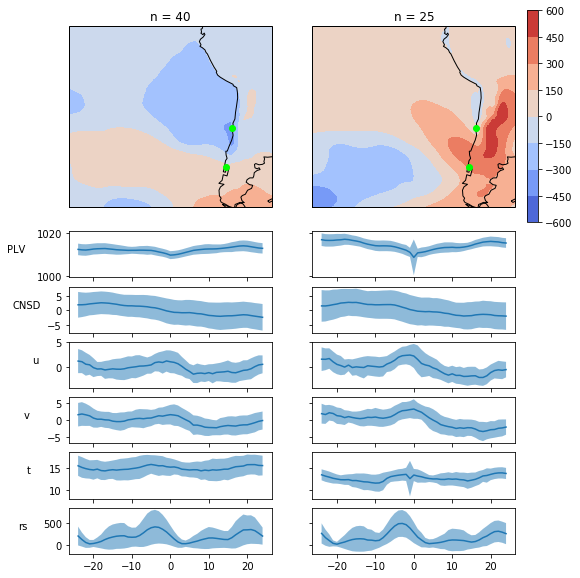

In [235]:
c = composite(X, ix, '1D')
pl = label_plot(slp, c, label(ix, g2), np.arange(-600, 650, 150))

Garreau et al. detection of coastal lows. First column refers to non-coastal lows and second to coastal lows as detected by the procedure; the *n=..* titles gives the number of events for each.

All plots are composites, the top maps of SLP at the day of culmination at *PLV*. The 1D plots give -/+ 24 h of the respective variables: *PLV* and *CNSD* refer to the pressure at those two locations, whereas the other variables are all at *PLV*. Values of pressure at *CNSD* and u, v winds at *PLV* are anomalies from the 10-day Lanczos-filtered data.

In [207]:
from mpl_toolkits.mplot3d import Axes3D

def label_hist(a, b, xlabel=None, ylabel=None, gridspec=gs.GridSpec(1, 1)[0]):
    l, c = np.unique(np.vstack((a, b)), axis=1, return_counts=True)
    n = l.shape[1]
    colors={True: 'r', False: 'b'}
    ax = plt.subplot(gridspec, projection='3d')
    ax.bar3d(*l, [0]*n, [.8]*n, [.8]*n, c, color=[colors[sum(i)==1] for i in l.T])
    ax.set_xticks([.4, 1.4])
    ax.set_xticklabels([0, 1])
    ax.set_yticks([.4, 1.4])
    ax.set_yticklabels([0, 1])
    if xlabel is not None: ax.set_xlabel(xlabel)
    if ylabel is not None: ax.set_ylabel(ylabel)

## Other attempts at detection (clustering etc)

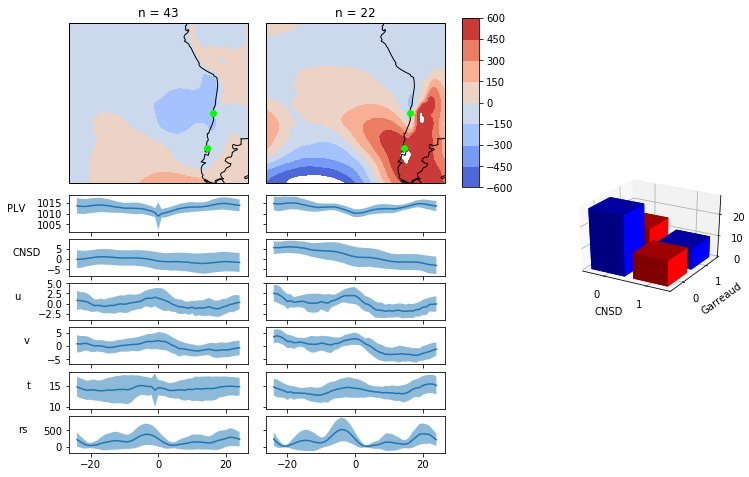

In [61]:
# this grid-in-grid only works if I don't call plt.show() for the individual sub-figures
c = composite(X, ix, '1D')

fig = plt.figure(figsize=(12, 8))
g = gs.GridSpec(3, 7)
ax = label_plot(slp, c, label(ix, idx), np.arange(-600, 650, 150), gridspec=g[:, :4], maph=4, wspace=.1)
label_hist(label(ix, idx), label(ix, g2), 'CNSD', 'Garreaud', g[1, 5:])

Here I use the detecting method that a maximum at *CNSD* has to occur within two days prior to a minimum at *PLV*. The plot on the right shows how the two detection methods compare (contingency table: vaguada costera = 1, migratory cyclone = 0). The matching cells of the contingency table are shown in blue, the differing ones in red.

### Clustering by SLP field from ERA

In [167]:
from sklearn import cluster
br = lambda x: x[(x >= '2016') & (x < '2017-07')] + pd.Timedelta('4h')

pp = slp.sel(time = br(ix).date.astype('datetime64')) - slp.mean('time')
x = pp.sel(lon=slice(-120, -60), lat=slice(0, -50)).stack(s=('lat', 'lon'))
km = cluster.KMeans(n_clusters=2).fit(x.values)

In [168]:
c = composite(X, ix, '1D')
i = pd.DatetimeIndex((c.indexes['events'] + pd.Timedelta('4h')).date)
d = c.isel(events=i.get_indexer(i.intersection(slp.time)))

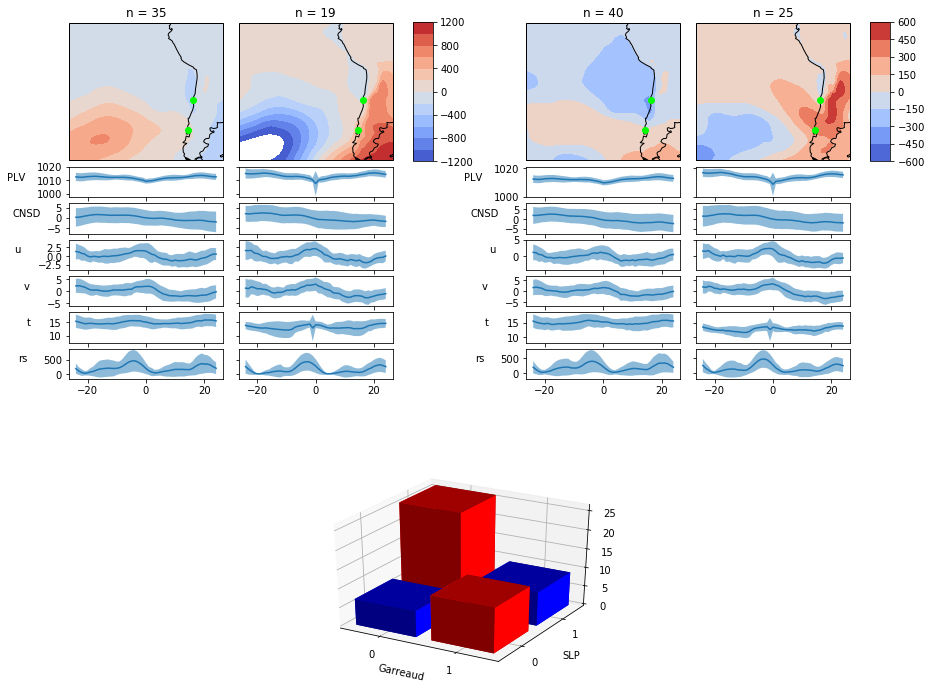

In [170]:
plt.figure(figsize=(14, 12))
g = gs.GridSpec(9, 7)
label_plot(slp, d, km.labels_, np.arange(-1200, 1300, 200), gridspec=g[:5, :3], maph=4, wspace=.1)
label_plot(slp, c, label(ix, g2), np.arange(-600, 650, 150), gridspec=g[:5, 4:], maph=4, wspace=.1)
label_hist(label(ix.intersection(d.events), g2.intersection(d.events)), 1-km.labels_, 'Garreaud', 'SLP', g[6:, 2:5])

Left plot shows a simple k-means applied to SLP fields from ERA in the region shown in the plot (120$^{\circ}$ W - 60$^{\circ}$ W, 0$^{\circ}$ - 50$^{\circ}$ S), for the days preselected according to the minimum finder. Below is the contingency table plot. **NOTE: The 'vaguada' type synoptic pattern is more associated with label 0 in this case (left plot), but below it is remapped to 1.**

### Clustering by wind direction at *PLV* and by pressure anomaly at *CNSD*

In [154]:
# cluster by wind direction prior to culmination
c1 = composite(D, ix, '1D', fillna=True)
c1['var'] = ('var', ['PLV', 'CNSD', 'vv', 'dv', 'rs', 'ta'])
k1 = cluster.KMeans(n_clusters=2).fit(c1[3, :, :25]) # <- :25 is the half of the composite before the culmination

# cluster by pressure anomalie at CNSD
c2 = composite(X, ix, '1D', fillna=True)
k2 = cluster.KMeans(n_clusters=2).fit(c2.sel(var='CNSD').squeeze())

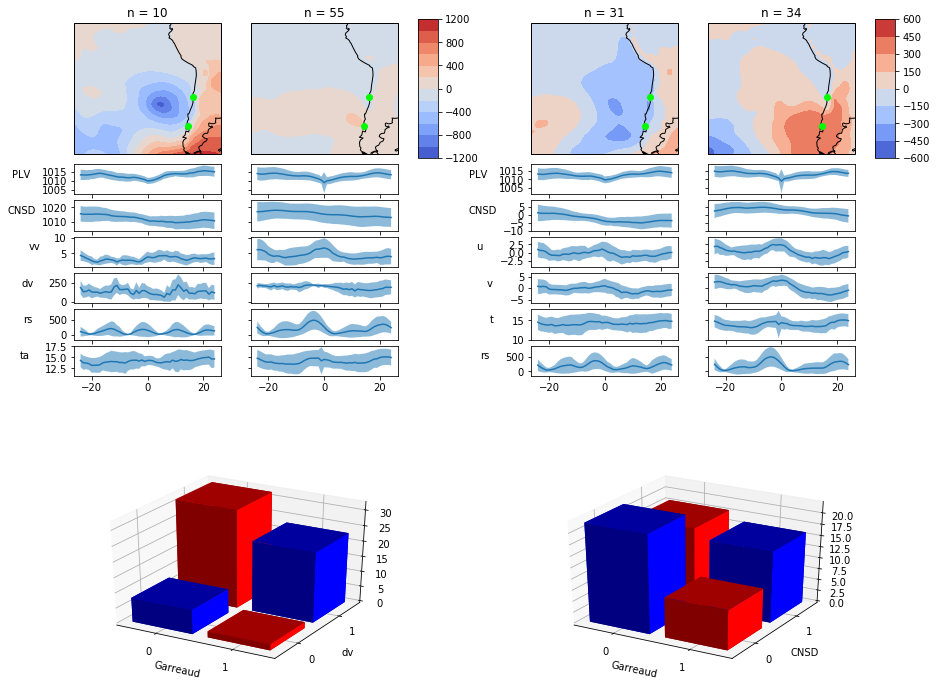

In [164]:
plt.figure(figsize=(14, 12))
g = gs.GridSpec(9, 7)
label_plot(slp, c1, k1.labels_, np.arange(-1200, 1201, 200), gridspec=g[:5, :3])
label_hist(label(ix, g2), k1.labels_, 'Garreaud', 'dv', g[6:, :3])
label_plot(slp, c2, k2.labels_, np.arange(-600, 601, 150), gridspec=g[:5, 4:])
label_hist(label(ix, g2), k2.labels_, 'Garreaud', 'CNSD', g[6:, 4:])

Left: clustering by the wind direction at *PLV* in the 24h prior to culmination; Right: by pressure anomalie at *CNSD*. **NOTE:** using absolute pressure at CNSD makes little difference. **Also, not that the variables plotted beneath the map are different for the two upper plots.**

In [171]:
def gt5(c):
    dp = (lambda x:x.max('dt') - x.min('dt'))(c.sel(var='PLV').isel(dt=slice(None, 25)))
    return c.sel(events=dp.values.flatten()>5)

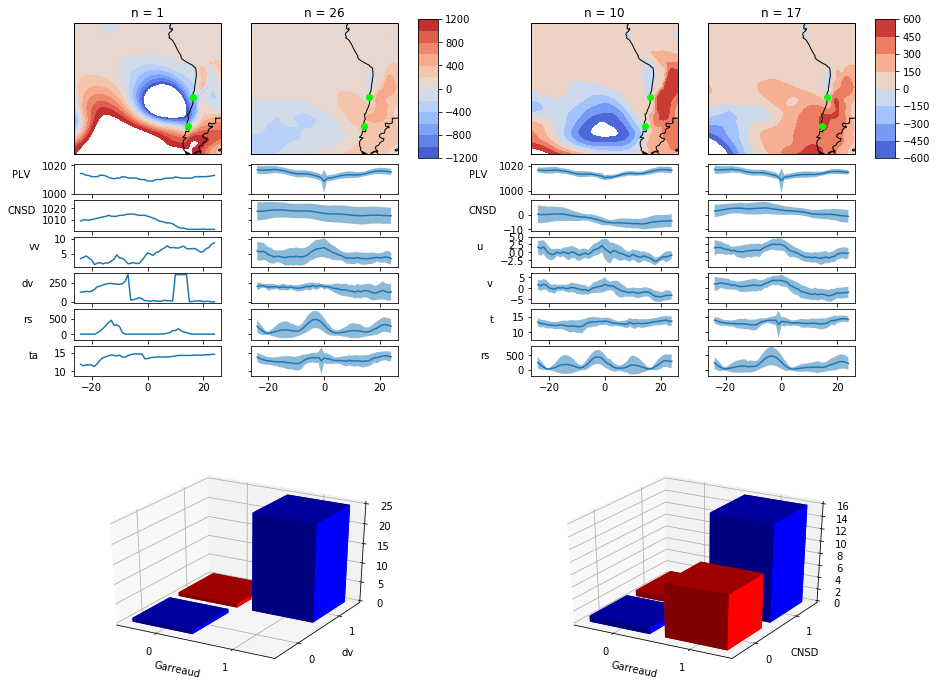

In [210]:
d1, d2 = [gt5(x) for x in [c1, c2]]
k1 = cluster.KMeans(n_clusters=2).fit(d1[3, :, :25])
k2 = cluster.KMeans(n_clusters=2).fit(d2.sel(var='CNSD').squeeze())

plt.figure(figsize=(14, 12))
g = gs.GridSpec(9, 7)
label_plot(slp, d1, 1-k1.labels_, np.arange(-1200, 1201, 200), gridspec=g[:5, :3])
label_hist(l, 1-k1.labels_, 'Garreaud', 'dv', g[6:, :3])
label_plot(slp, d2, k2.labels_, np.arange(-600, 601, 150), gridspec=g[:5, 4:])
label_hist(l, k2.labels_, 'Garreaud', 'CNSD', g[6:, 4:])

Same plot as above, but restricted to culminations at *PLV* with 24h-drop in pressure in excess of 5 hPa. This largely maps onto the Garreaud et al. criterium anyways, hence only one non-vaguada event in the left plot.

### 3 quantiles of pressure anomaly at *CNSD*

In [211]:
# get quantiles (3 equal parts)
def quant(x):
    i = np.ones_like(x)
    q = x.quantile([.3, .6]).as_matrix().flatten()
    a, b = x <= q[0], x >= q[1]
    return (2 * i * b + i * (~a & ~b)).values.flatten()

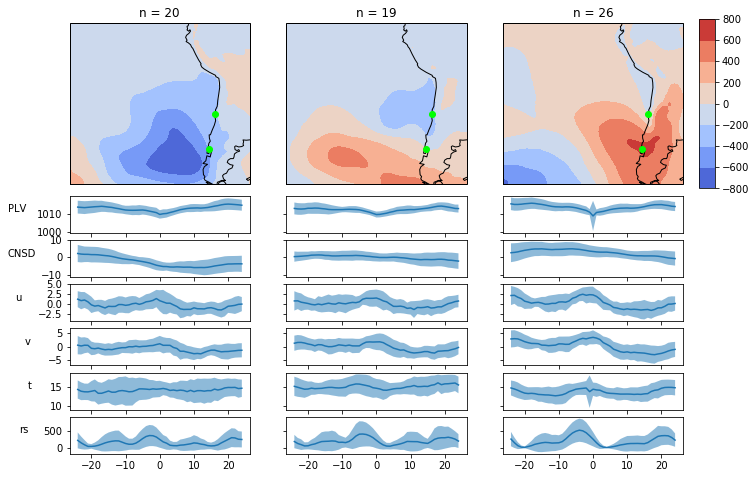

In [221]:
# pressure at CNSD divided into 3 equal quantiles (after pre-selection by minimum at PLV)
c = composite(X, ix, '1D')
labels = quant(D.loc[ix][('pa_hpa', 'CNSD')])

plt.figure(figsize=(11, 8))
label_plot(slp, c, labels, np.arange(-800, 801, 200))

Composites for the 3 equal quantiles of pressure anomaly at *CNSD* after pre-selection by the 5-day minima at *PLV*.

### Clustering by u and v at *PLV*

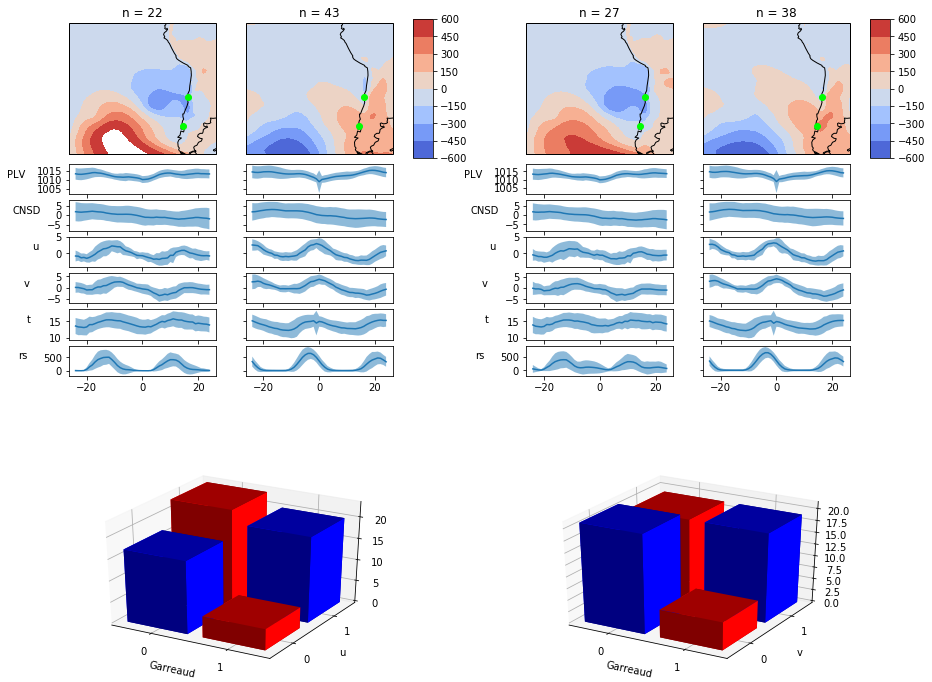

In [227]:
k1 = cluster.KMeans(n_clusters=2).fit(c.sel(var='u').squeeze())
k2 = cluster.KMeans(n_clusters=2).fit(c.sel(var='v').squeeze())

plt.figure(figsize=(14, 12))
g = gs.GridSpec(9, 7)
label_plot(slp, c, 1-k1.labels_, np.arange(-600, 601, 150), gridspec=g[:5, :3])
label_hist(label(ix, g2), 1-k1.labels_, 'Garreaud', 'u', g[6:, :3])
label_plot(slp, c, k2.labels_, np.arange(-600, 601, 150), gridspec=g[:5, 4:])
label_hist(label(ix, g2), k2.labels_, 'Garreaud', 'v', g[6:, 4:])

Using anomalies of u (left) and v (right) velocities computed at *PLV* for clustering.

### Clustering by solar radiation at *PLV*

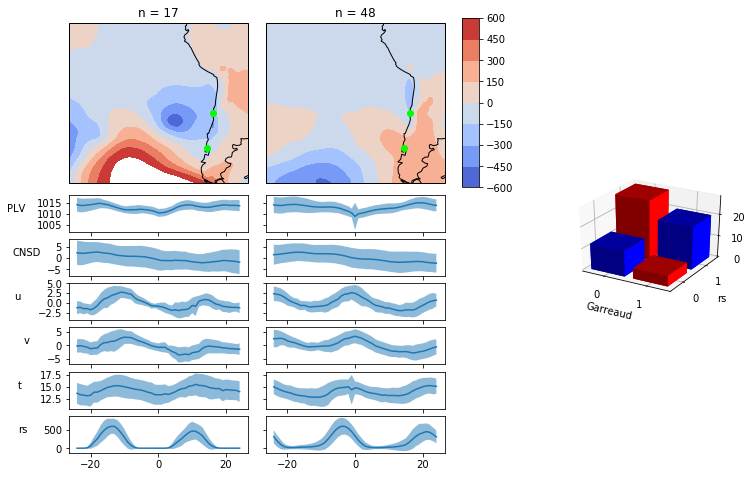

In [235]:
c = composite(X, ix, '1D', fillna=True)
km = cluster.KMeans(n_clusters=2).fit(c.sel(var='rs').squeeze())

fig = plt.figure(figsize=(12, 8))
g = gs.GridSpec(3, 7)
ax = label_plot(slp, c, 1-km.labels_, np.arange(-600, 650, 150), gridspec=g[:, :4], maph=4, wspace=.1)
label_hist(label(ix, g2), 1-km.labels_, 'Garreaud', 'rs', g[1, 5:])

Using raw solar radiation at *PLV* to cluster. **Is this equivalent to clustering based on times of day when the culmination occurs?**

## WRF errors

In [65]:
def compositeXR(var, locs, period):
    dt = pd.Timedelta(period)
    ix = np.abs(np.expand_dims(var.XTIME, 2) - locs.values.reshape((1, 1, -1))) <= dt.asm8
    ix = ix * np.expand_dims(~np.isnat(var.XTIME), 2).repeat(ix.shape[2], 2)
    i = ix.reshape((-1, len(locs))).sum(0) > 0
    ix = ix[:, :, i]
    def series(x, s, loc):
        try:
            y = x.sel(start=s)
            c = (loc - s).values.astype('timedelta64[D]').astype(int)
            dt = (y.XTIME - loc).values.astype('timedelta64[h]').astype(int)
            return pd.DataFrame(y.values, index=dt, columns=[c]).dropna(0)
        except: return None
    def loc(k, loc):
        try:
            x = var.where(ix[:, :, k]).dropna('start', 'all').dropna('Time', 'all')
            return pd.concat([series(x, s, loc) for s in x.start], 1)
        except: return None
    x = pd.concat([loc(k, l) for k, l in enumerate(locs.values[i])], 1, keys=locs.values[i])
    x.columns = x.columns.swaplevel()
    return x.sort_index(1)

def cutc(x):
    return x.loc[:, x.columns.get_level_values(0)>0]

def relabel(ix, df, labels):
    idx = df.columns.get_level_values(1)
    lab = np.unique(labels)
    i = [df.iloc[:, idx.get_indexer_for(ix[labels==i].intersection(idx).unique())] for i in lab]
    return pd.concat(i, 1, keys=lab).sort_index(1)

In [76]:
ix = extrema(D[('pa_hpa', 'PLV')], np.argmin, '5D')
c = composite(D, ix, '1D', fillna=True)

/home/arno/Documents/code/conda/envs/bayes/lib/python3.6/site-packages/ipykernel/kernelbase.py:399: PerformanceWarning: indexing past lexsort depth may impact performance.
  user_expressions, allow_stdin)


In [58]:
TP = xr.open_dataset('../../data/WRF/3d/PSFC_T20.nc')
# round it to nearest hour (only a pandas.Series has the .dt accessor with rounding)
TP['XTIME'] = (TP.XTIME.dims, pd.Series(TP.XTIME.values.flatten()).dt.round('h').values.reshape(TP.XTIME.shape))

In [78]:
# compositeXR returns the simulation lead day as column headers
# the cutc() function drops negative lead days (which can happen because of the way I compute it)
T_PLV = cutc(compositeXR(TP['T2'].sel(station='PLV'), ix, '1D'))
P_PLV = cutc(compositeXR(TP['PSFC'].sel(station='PLV'), ix, '1D'))

/home/arno/Documents/code/conda/envs/bayes/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: In the future, 'NAT <= x' and 'x <= NAT' will always be False.
  This is separate from the ipykernel package so we can avoid doing imports until


In [187]:
def error_plot(x, c=None, gridspec=gs.GridSpec(1, 1)[0], xlab='off', ypos='left'):
    g = gs.GridSpecFromSubplotSpec(1, 2, subplot_spec=gridspec)
    ax = plt.gcf().add_subplot(g[0])
    nx = x[0].columns.get_level_values(1).unique()
    ax.plot(x[0].mean(1, level=0))
    if c is not None:
        ax.plot(c['dt'], c.sel(events=nx).mean('events').values.flatten())
    ax.set_title('n = {}'.format(nx.size))

    bx = plt.gcf().add_subplot(g[1], sharey=ax)
    nx = x[1].columns.get_level_values(1).unique()
    bx.plot(x[1].mean(1, level=0))
    if c is not None:
        bx.plot(c['dt'], c.sel(events=nx).mean('events').values.flatten())
    bx.set_title('n = {}'.format(nx.size))
    
    if xlab=='off':
        plt.setp(ax.get_xticklabels(), visible=False)
        plt.setp(bx.get_xticklabels(), visible=False)
    if ypos=='left':
        plt.setp(bx.get_yticklabels(), visible=False)       
    else:
        plt.setp(ax.get_yticklabels(), visible=False)
        bx.yaxis.tick_right()
    return bx

In [215]:
T2 = S['ta_c'].xs('prom', 1, 'aggr')
T2 = T2.loc[:, T2.columns.get_level_values('elev').astype(float) < 10]
DT = TP['T2'] - 273.15 - align_stations(TP, T2)
dt = cutc(compositeXR(DT.sel(station='PLV'), ix, '1D'))

PSFC = S['pa_hpa'].xs('prom', 1, 'aggr')
DP = TP['PSFC'] / 100 - align_stations(TP, PSFC)
dp = cutc(compositeXR(DP.sel(station='PLV'), ix, '1D'))

/home/arno/Documents/code/conda/envs/bayes/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: In the future, 'NAT <= x' and 'x <= NAT' will always be False.
  This is separate from the ipykernel package so we can avoid doing imports until


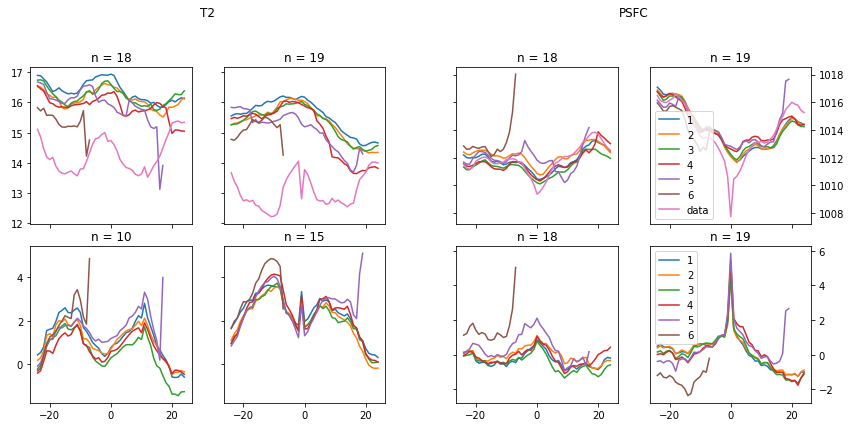

In [204]:
fig = plt.figure(figsize=(14, 7))
g = gs.GridSpec(9, 2, hspace=1)
ax = fig.add_subplot(g[:, 0])
ax.axis('off')
ax.set_title('T2')

ax = fig.add_subplot(g[:, 1])
ax.axis('off')
ax.set_title('PSFC')

# add different labelling / different stations later
for labels in [label(ix, g2)]:
    ax = error_plot(relabel(ix, T_PLV - 273.15, labels), c.sel(var='ta_c'), g[1:5, 0])
    bx = error_plot(relabel(ix, P_PLV / 100, labels), c.sel(var=('pa_hpa', 'PLV')), g[1:5, 1], ypos='right')
    bx.legend([1,2,3,4,5,6,'data'])

    ax = error_plot(relabel(ix, dt, labels), gridspec=g[5:, 0], xlab='on')
    bx = error_plot(relabel(ix, dp, labels), gridspec=g[5:, 1], xlab='on', ypos='right')
    bx.legend([1,2,3,4,5,6])

In [211]:
T_CHILL = cutc(compositeXR(TP['T2'].sel(station='CHILL'), ix, '1D'))
P_CHILL = cutc(compositeXR(TP['PSFC'].sel(station='CHILL'), ix, '1D'))

/home/arno/Documents/code/conda/envs/bayes/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: In the future, 'NAT <= x' and 'x <= NAT' will always be False.
  This is separate from the ipykernel package so we can avoid doing imports until


In [230]:
c = composite(pd.concat((T2['CHILL'], PSFC['CHILL']), 1), ix, '1D', fillna=True)

/home/arno/Documents/code/conda/envs/bayes/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: In the future, 'NAT <= x' and 'x <= NAT' will always be False.
  This is separate from the ipykernel package so we can avoid doing imports until


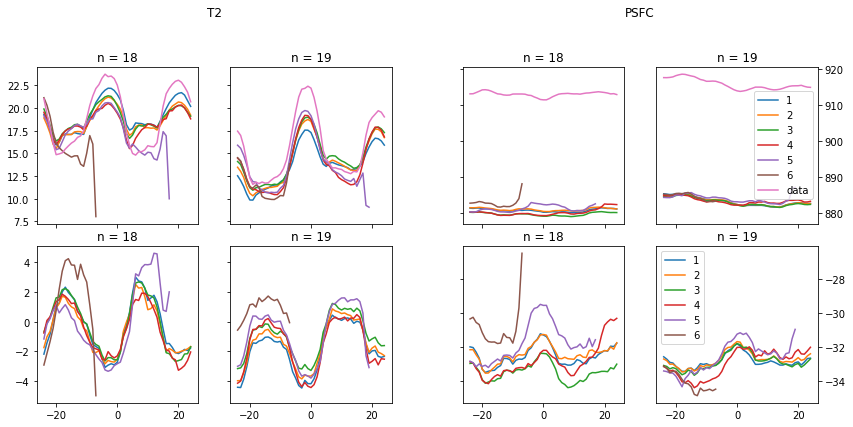

In [233]:
dt = cutc(compositeXR(DT.sel(station='CHILL'), ix, '1D'))
dp = cutc(compositeXR(DP.sel(station='CHILL'), ix, '1D'))

fig = plt.figure(figsize=(14, 7))
g = gs.GridSpec(9, 2, hspace=1)
ax = fig.add_subplot(g[:, 0])
ax.axis('off')
ax.set_title('T2')

ax = fig.add_subplot(g[:, 1])
ax.axis('off')
ax.set_title('PSFC')

# add different labelling / different stations later
for labels in [label(ix, g2)]:
    ax = error_plot(relabel(ix, T_CHILL - 273.15, labels), c.sel(var='ta_c'), g[1:5, 0])
    bx = error_plot(relabel(ix, P_CHILL / 100, labels), c.sel(var='pa_hpa'), g[1:5, 1], ypos='right')
    bx.legend([1,2,3,4,5,6,'data'])

    ax = error_plot(relabel(ix, dt, labels), gridspec=g[5:, 0], xlab='on')
    bx = error_plot(relabel(ix, dp, labels), gridspec=g[5:, 1], xlab='on', ypos='right')
    bx.legend([1,2,3,4,5,6])

# Stuff

In [531]:
p = D['pa_hpa'][['MARPCH', 'LSC', 'UCNG', '4', 'PLV', 'CT']].xs('prom', 1, 'aggr')

In [528]:
p = expand(D['pa_hpa']['4']['2016':].xs('prom', 1, 'aggr'), 24)
x = argrelmin(p.values, order=10)[0]
c = pd.concat((p, p.rolling('1D').max()), 1).iloc[x]
pc = composite(p, x, 24)

/home/arno/Documents/code/conda/envs/bayes/lib/python3.6/site-packages/scipy/signal/_peak_finding.py:68: RuntimeWarning: invalid value encountered in less
  results &= comparator(main, plus)
/home/arno/Documents/code/conda/envs/bayes/lib/python3.6/site-packages/scipy/signal/_peak_finding.py:69: RuntimeWarning: invalid value encountered in less
  results &= comparator(main, minus)


In [111]:
from sklearn import cluster

def distance_matrix(x):
    x = x - np.nanmean(x, 1, keepdims=True) # remove mean pressure for each episode
    n = x.shape[0]
    d = np.zeros((n, n))
    for i in range(n):
        for j in range(i):
            d[i, j] = np.nanmean((x[i, :] - x[j, :]) ** 2) ** .5
    return d + d.T # make it symmetric

dp = distance_matrix(pc)

db = cluster.SpectralClustering(n_clusters=3, affinity='precomputed').fit(dp)

In [14]:
from scipy.interpolate import interpn
def intp(x, i, sta):
    return interpn((x.lat, x.lon-360), x.sel(time=i), sta[['lat', 'lon']].astype(float))

<IPython.core.display.Javascript object>


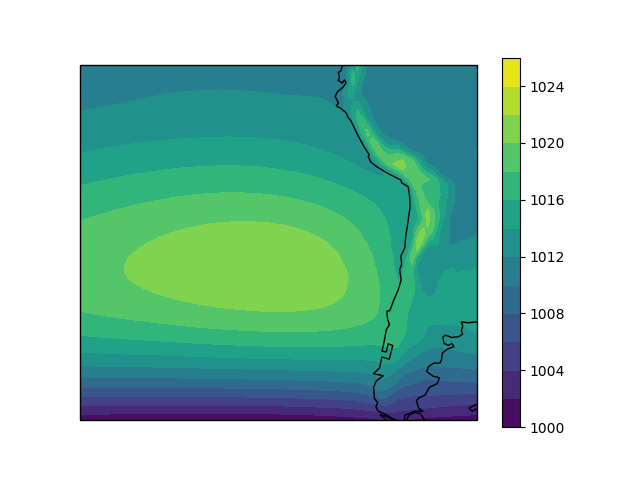

In [291]:
# pm = slp.mean('time')

fig, ax = plt.subplots(subplot_kw={'projection': crs.PlateCarree()})
cnt = np.arange(1000, 1027, 2)

plt.contourf(pm.lon, pm.lat, pm.squeeze()/100, cnt)
ax.set_extent([-120, -60, -50, 0])
ax.coastlines()
plt.colorbar(pl, ax=ax)

<IPython.core.display.Javascript object>


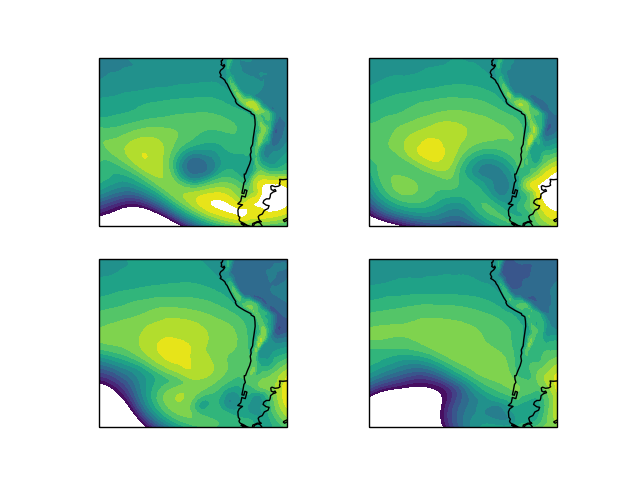

In [289]:
fig, axs = plt.subplots(2, 2, subplot_kw={'projection': crs.PlateCarree()})

cnt = np.arange(1000, 1027, 2)

for i in range(4):
    ax = axs[i//2, i%2]
    pp = slp.sel(time = (m.index[-1] + pd.Timedelta(i-2, 'D')).strftime('%Y-%m-%d'))
    pl = ax.contourf(pp.lon, pp.lat, pp.squeeze()/100, cnt)
    ax.set_extent([-120, -60, -50, 0])
    ax.coastlines()
#     plt.colorbar(pl, ax=ax)

In [317]:
# 5 day mins / maxs
ix = extrema(p['PLV'], np.argmin, '5D')  # Punta Lengua de Vaca
jx = extrema(p['CNSD'], np.argmax, '5D') # Senda Darwin

# coastal low index based on maximum at CNSD occurring within 2 days prior to a minimum at PLV
r = pd.concat((p['CNSD'].loc[jx], p['PLV'].loc[ix]), 1).rolling('2.5D')
idx = pd.concat((r.count().iloc[:, 0], p['PLV'].loc[ix]), 1).dropna(0, 'any').index

# adapt to ERA indexes
br = lambda x: x[(x >= '2016') & (x < '2017-07')] + pd.Timedelta('4h')
ai = br(idx)
bi = br(ix.symmetric_difference(idx))

len(ai), len(bi)

(20, 34)

<IPython.core.display.Javascript object>


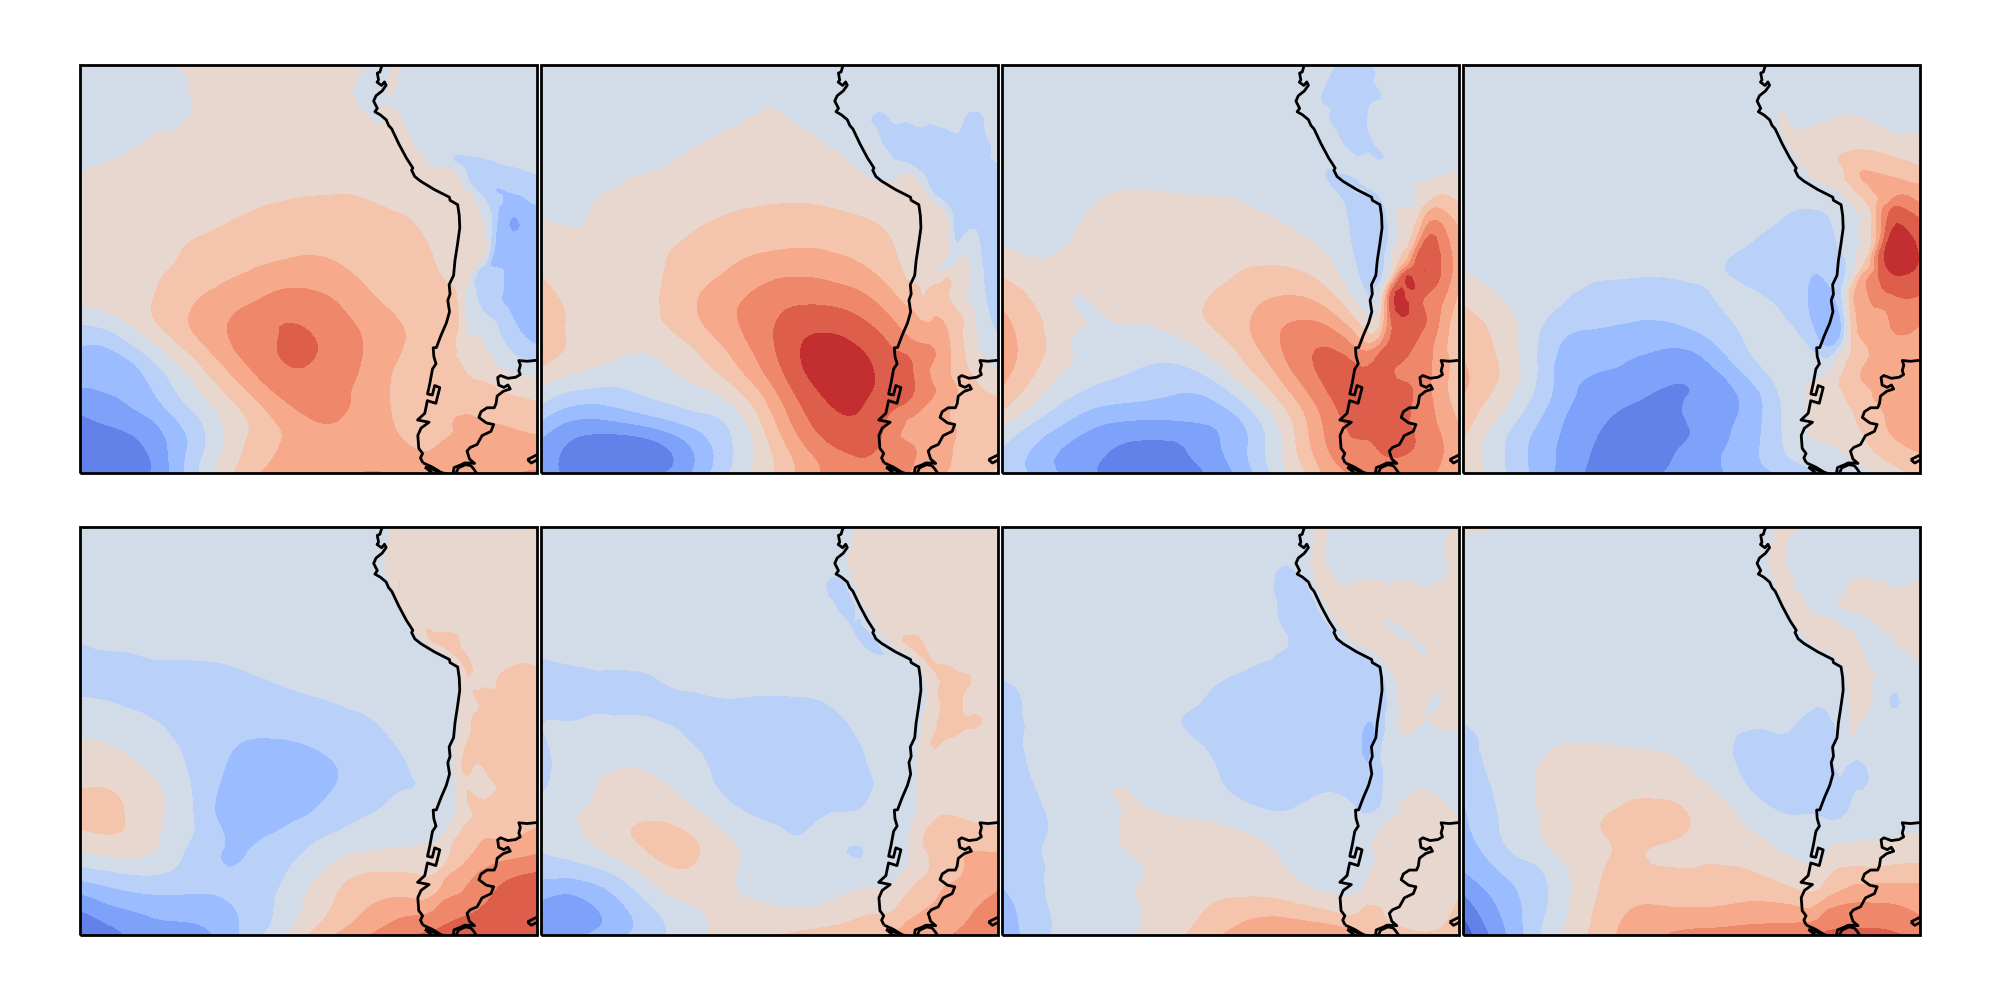

In [127]:
fig, axs = plt.subplots(2, 4, subplot_kw={'projection': crs.PlateCarree()}, figsize=(10, 5))
fig.subplots_adjust(top=.96, bottom=.04, left=.04, right=.96, wspace=.01, hspace=.01)

cnt = np.arange(-6, 6.1)
plt.set_cmap('coolwarm')

slpm = slp.mean('time')

for j, t in enumerate([ai, bi]):
    for i in range(4):
        ax = axs[j, i]
        pp = slp.sel(time = t.date.astype('datetime64') + pd.Timedelta(i-2, 'D')).mean('time') - slpm
        pl = ax.contourf(pp.lon, pp.lat, pp.squeeze()/100, cnt)
        ax.set_extent([-120, -60, -50, 0])
        ax.coastlines()

In [128]:
p = D['pa_hpa']['PLV']['2016':].dropna().resample('h').first()

In [140]:
cwt = sig.cwt(p.values.flatten(), sig.ricker, np.arange(24, 240))

In [141]:
abs(cwt).max()

6375.0140427373281

<IPython.core.display.Javascript object>


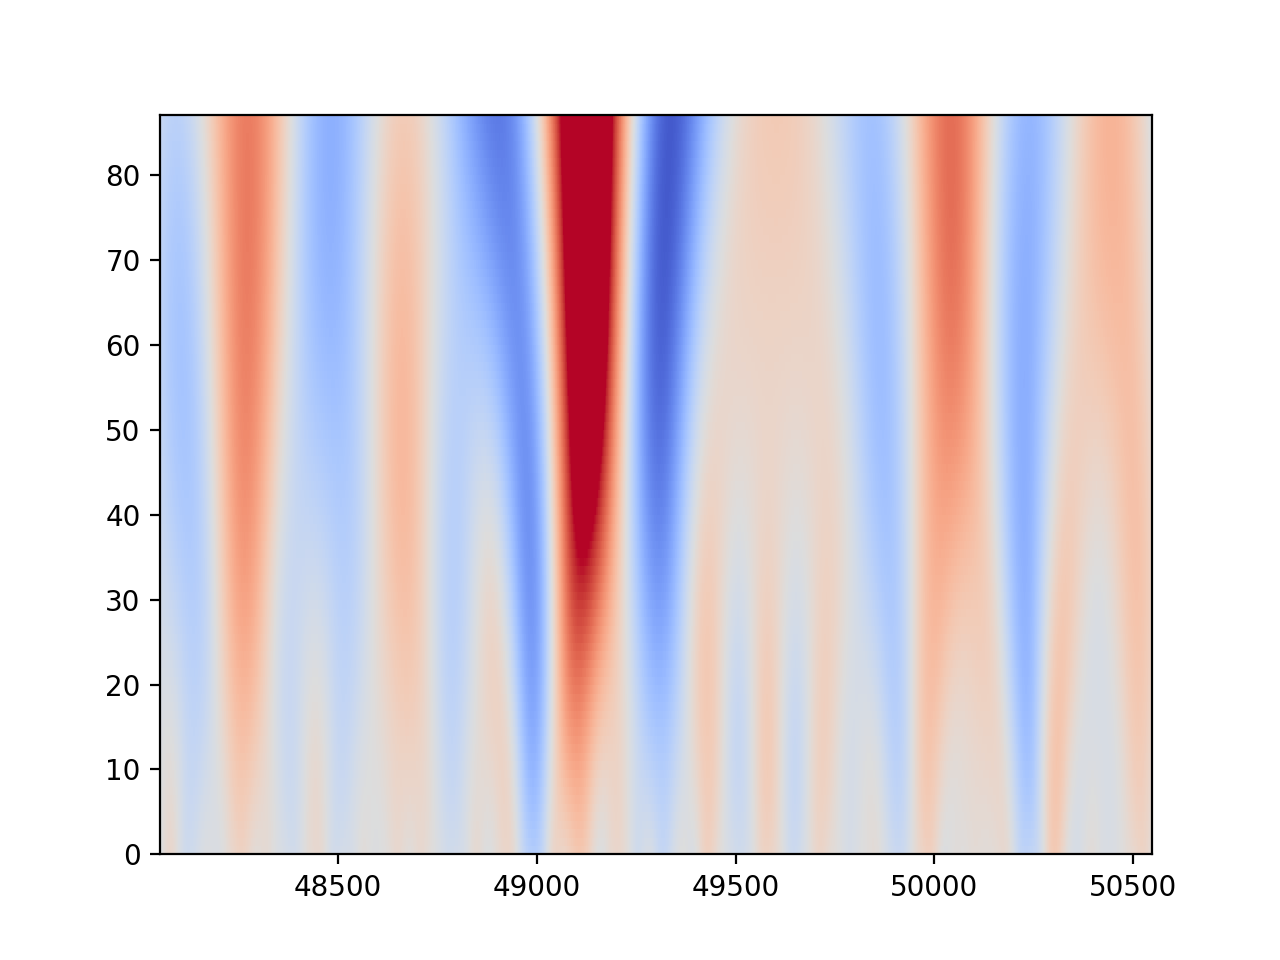

In [142]:
plt.figure()
plt.pcolormesh(cwt, vmin=-50, vmax=50)

In [478]:
D = pd.concat([
    S['pa_hpa'][['PLV', 'CNSD']],
    S['vv_ms'].xs('PLV', 1, 'station', drop_level=False),
    S['dv'].xs('PLV', 1, 'station', drop_level=False),    
    S['rs_w'].xs('PLV', 1, 'station', drop_level=False)
], 1).xs('prom', 1, 'aggr').dropna(0, 'all').resample('h').first()
D.columns = D.columns.swaplevel(0, 1)

In [338]:
ix = extrema(D[('pa_hpa', 'PLV')]['2016':'2017'], np.argmin, '5D')
c = composite(D, ix, '1D', fillna=True)

/home/arno/Documents/code/conda/envs/bayes/lib/python3.6/site-packages/ipykernel/kernelbase.py:399: PerformanceWarning: indexing past lexsort depth may impact performance.
  user_expressions, allow_stdin)


In [672]:
w = Lanczos(D, '3D', 3)
y = D.rolling(w.N, center=True, min_periods=0).apply(w)

<IPython.core.display.Javascript object>


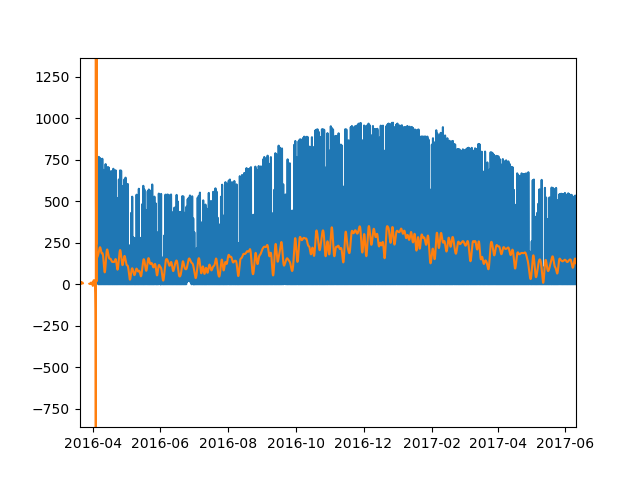

In [673]:
plt.figure()
plt.plot(D.iloc[:, 4])
plt.plot(y.iloc[:, 4])

In [1553]:
x = DT.sel(station='PLV')

<IPython.core.display.Javascript object>


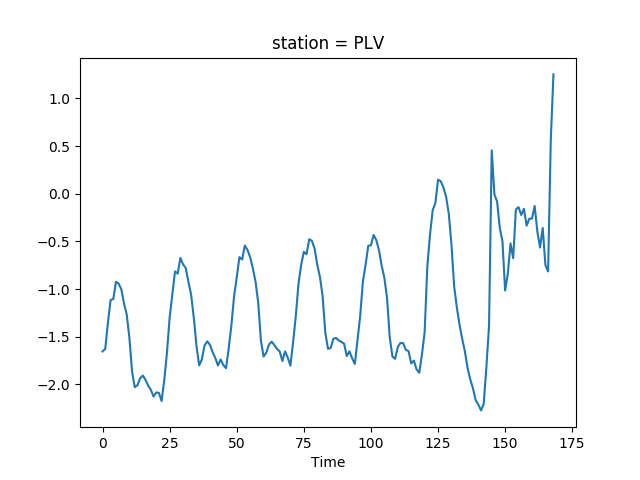

In [1557]:
fig, ax = plt.subplots()
x.mean('start').plot(ax = ax)

In [1599]:
x = DT.isel(Time=slice(0, 96)).mean(['start', 'Time'])

In [1564]:
with pd.HDFStore('../../data/CEAZAMet/stations.h5') as SS:
    sta = SS['stations']

In [1587]:
from plots import Coquimbo
coq = Coquimbo()

<IPython.core.display.Javascript object>


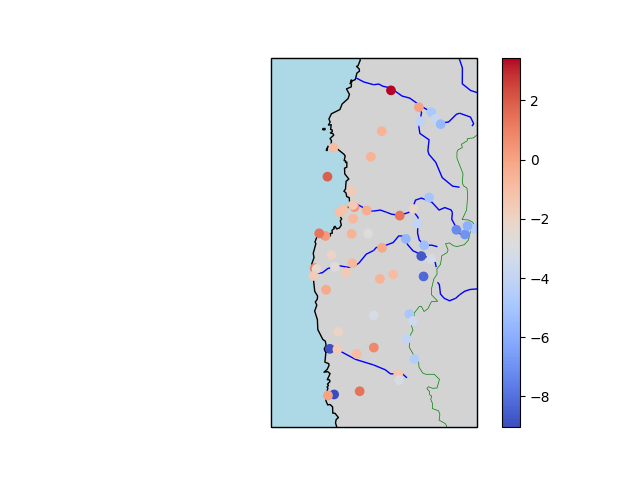

In [1600]:
fig, ax = plt.subplots(subplot_kw={'projection': crs.PlateCarree()})
plt.scatter(*sta.loc[DT.station][['lon', 'lat']].as_matrix().T, c=x)
plt.colorbar()
coq(ax)

In [1595]:
reload(plots)
coq = plots.Coquimbo()